<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments <br>
Prediction EnergyUse</font></b>

Ce notebook est la suite du notebook d'exploration des données Deveau_Estelle_1_notebook_exploratoire_022024

# Introduction

## Imports

In [116]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
import time
from scipy.stats import uniform
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, loguniform

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb-test.ipynb',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/cleaned/")

['df_cleaned.csv']

In [4]:
path     = "./data/cleaned/"
filename = "df_cleaned.csv"

In [5]:
df = pd.read_csv(path + filename)
df.head()

,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,...,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_DataCenter,GFA_Supermarche,GFA_Hopital,GFA_Laboratoire,GFA_Parking,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
0,1.0,12,60.0,7456910.0,249.98,89,1,26.872820,52.917723,17.117720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,1.0,10,56.0,6946800.5,286.43,90,1,31.877211,39.858983,26.072621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.657494,15.753792
2,1.0,11,27.0,6062767.5,176.14,90,1,0.000000,46.368511,48.617731,...,0.0,1656.0,0.0,0.0,0.0,0.0,0.0,0.0,5.171279,15.617677
3,1.0,8,NaN,7067881.5,221.51,90,1,32.206065,51.453254,5.449851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.400468,15.771071
4,1.0,15,43.0,14194054.0,392.16,112,1,0.000000,51.415325,45.271774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.971670,16.468334


In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# Suppression des individus avec une valeur non nulle dans , 'GFA_Laboratoire_Hopital'
df = df[df['GFA_Laboratoire'] == 0]
df = df[df['GFA_Hopital'] == 0]
df = df[df['GFA_DataCenter'] == 0]

#Suppression de la colonne GFA_Laboratoire_Hopital
df.drop(columns=['GFA_Laboratoire','GFA_Hopital','GFA_DataCenter'], inplace=True)



In [8]:
df.shape

(932, 22)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 932 entries, 0 to 958
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         932 non-null    float64
 1   NumberofFloors            932 non-null    int64  
 2   ENERGYSTARScore           593 non-null    float64
 3   SiteEnergyUseWN(kBtu)     932 non-null    float64
 4   TotalGHGEmissions         932 non-null    float64
 5   BuildingAge               932 non-null    int64  
 6   NumberOfPropertyUseTypes  932 non-null    int64  
 7   SteamUse_pct              932 non-null    float64
 8   Electricity_pct           932 non-null    float64
 9   NaturalGas_pct            932 non-null    float64
 10  GFA_Résidences            932 non-null    float64
 11  GFA_Public_loisirs        932 non-null    float64
 12  GFA_Education             932 non-null    float64
 13  GFA_Commerces             932 non-null    float64
 14  GFA_Bureaux_ser

In [10]:
df.describe()

,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
count,932.000000,932.000000,593.000000,9.320000e+02,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,1.064378,2.957082,61.401349,4.147875e+06,89.469968,58.978541,1.798283,1.582920,64.660039,28.166344,4942.786481,2175.883047,4235.289700,6963.161159,24063.503863,14278.743562,6205.094957,706.583691,1620.991416,4381.689914,3.695351,14.660900
std,0.503625,3.567710,29.025515,5.045381e+06,126.802444,31.268313,1.160613,7.752786,27.030835,23.873144,22613.712592,10062.991428,22797.539538,31738.262890,57161.966073,33414.866406,28917.370837,3964.864932,9010.813106,22754.617103,1.356111,1.088866
min,1.000000,1.000000,1.000000,5.811420e+04,0.400000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.916291,10.970165
25%,1.000000,1.000000,41.000000,1.124651e+06,17.850000,36.000000,1.000000,0.000000,42.519471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.882002,13.932959
50%,1.000000,2.000000,68.000000,2.112176e+06,42.215000,55.000000,1.000000,0.000000,62.780980,28.670099,0.000000,0.000000,0.000000,0.000000,1175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.742775,14.563228
75%,1.000000,3.000000,86.000000,5.061240e+06,101.235000,88.000000,2.000000,0.000000,93.836110,47.816848,0.000000,0.000000,0.000000,0.000000,24867.250000,19811.750000,997.000000,0.000000,0.000000,0.000000,4.617444,15.437120
max,10.000000,42.000000,100.000000,2.999738e+07,1060.130000,116.000000,9.000000,64.773098,100.000000,97.077764,244500.000000,134197.000000,367884.000000,509342.000000,748011.000000,407491.000000,400149.000000,50000.000000,121087.000000,379067.000000,6.966147,17.216621


Dans un premier temps, nous allons travailler en excluant l'ENERGYSTARScore puis nous ferons une comparaison avec son utilisation.

# Modelisation sans l'Energy Star Score

## Importance des features

### Data preparation

On supprime NaturalGas_pct car déductibles des autres features.

In [11]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore'], axis=1)
target = df['SiteEnergyUseWN(kBtu)']

In [12]:
features.head(1)

,NumberofBuildings,NumberofFloors,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
0,1.0,12,89,1,26.87282,52.917723,17.11772,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Séparation des données

In [13]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((745, 17), (187, 17))

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 57 to 108
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumberofBuildings         745 non-null    float64
 1   NumberofFloors            745 non-null    int64  
 2   BuildingAge               745 non-null    int64  
 3   NumberOfPropertyUseTypes  745 non-null    int64  
 4   SteamUse_pct              745 non-null    float64
 5   Electricity_pct           745 non-null    float64
 6   NaturalGas_pct            745 non-null    float64
 7   GFA_Résidences            745 non-null    float64
 8   GFA_Public_loisirs        745 non-null    float64
 9   GFA_Education             745 non-null    float64
 10  GFA_Commerces             745 non-null    float64
 11  GFA_Bureaux_services      745 non-null    float64
 12  GFA_Industrie_entrepots   745 non-null    float64
 13  GFA_Autres                745 non-null    float64
 14  GFA_Restaurati

In [15]:
X_train.head()

,NumberofBuildings,NumberofFloors,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
57,1.0,3,43,1,0.0,40.443889,48.176474,0.0,0.0,0.0,0.0,0.0,0.0,56000.0,0.0,0.0,0.0
317,1.0,3,37,1,0.0,99.868372,0.131620,0.0,0.0,0.0,0.0,43495.0,0.0,5.0,0.0,0.0,0.0
523,1.0,2,36,1,0.0,26.607832,60.367486,0.0,0.0,0.0,0.0,0.0,33576.0,0.0,0.0,0.0,0.0
835,1.0,3,116,2,0.0,51.232578,46.906065,0.0,0.0,0.0,0.0,16838.0,0.0,10000.0,0.0,0.0,0.0
412,1.0,2,34,2,0.0,93.435384,0.000000,0.0,0.0,0.0,0.0,31800.0,8200.0,29.0,0.0,0.0,0.0


In [16]:
y_train.head()

57     2088978.125
317    3220635.250
523    1466199.875
835    2139205.250
412    1575328.250
Name: SiteEnergyUseWN(kBtu), dtype: float64

### Standardisation

In [17]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [18]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofBuildings,NumberofFloors,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
57,-0.117255,0.002492,-0.531103,-0.668414,-0.195125,-0.889010,0.833674,-0.21886,-0.233834,-0.185897,-0.206684,-0.411184,-0.450832,1.816323,-0.182352,-0.168433,-0.180509
317,-0.117255,0.002492,-0.726175,-0.668414,-0.195125,1.286806,-1.166292,-0.21886,-0.233834,-0.185897,-0.206684,0.318010,-0.450832,-0.217646,-0.182352,-0.168433,-0.180509
523,-0.117255,-0.262780,-0.758688,-0.668414,-0.195125,-1.395615,1.341149,-0.21886,-0.233834,-0.185897,-0.206684,-0.411184,0.625881,-0.217827,-0.182352,-0.168433,-0.180509
835,-0.117255,0.002492,1.842278,0.167103,-0.195125,-0.493984,0.780790,-0.21886,-0.233834,-0.185897,-0.206684,-0.128895,-0.450832,0.145414,-0.182352,-0.168433,-0.180509
412,-0.117255,-0.262780,-0.823712,0.167103,-0.195125,1.051263,-1.171771,-0.21886,-0.233834,-0.185897,-0.206684,0.121943,-0.187875,-0.216774,-0.182352,-0.168433,-0.180509


### Test de Student

In [19]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.694
Model:                               OLS   Adj. R-squared:                  0.686
Method:                    Least Squares   F-statistic:                     96.83
Date:                   Sat, 24 Feb 2024   Prob (F-statistic):          1.41e-173
Time:                           20:54:08   Log-Likelihood:                -12117.
No. Observations:                    745   AIC:                         2.427e+04
Df Residuals:                        727   BIC:                         2.435e+04
Df Model:                             17                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [20]:
# Suppression du NumberofFloors
X_train_scaled_df.drop(columns=['NumberOfPropertyUseTypes'], inplace=True)

In [21]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.694
Model:                               OLS   Adj. R-squared:                  0.687
Method:                    Least Squares   F-statistic:                     103.0
Date:                   Sat, 24 Feb 2024   Prob (F-statistic):          1.46e-174
Time:                           20:54:09   Log-Likelihood:                -12117.
No. Observations:                    745   AIC:                         2.427e+04
Df Residuals:                        728   BIC:                         2.435e+04
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [22]:
# Suppression du NumberofFloors
X_train_scaled_df.drop(columns=['NumberofFloors'], inplace=True)

In [23]:
# Ajout d'une constante à X pour le terme d'interception
X_train_const = sm.add_constant(X_train_scaled_df)

# Ajuster le modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Obtenir et afficher le résumé du modèle
summary = model.summary()
print(summary)

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.694
Model:                               OLS   Adj. R-squared:                  0.687
Method:                    Least Squares   F-statistic:                     110.0
Date:                   Sat, 24 Feb 2024   Prob (F-statistic):          1.50e-175
Time:                           20:54:09   Log-Likelihood:                -12117.
No. Observations:                    745   AIC:                         2.427e+04
Df Residuals:                        729   BIC:                         2.434e+04
Df Model:                             15                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

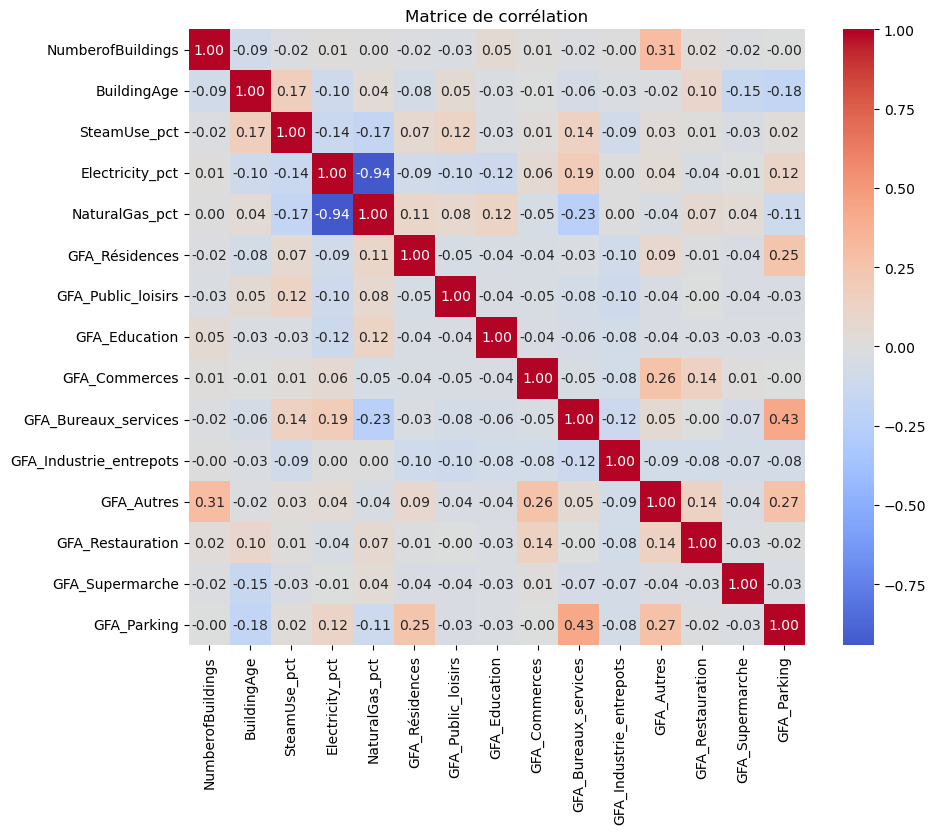

In [24]:
# Calcul de la matrice de corrélation
corr_matrix = X_train_scaled_df.corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, center=0)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

## Tests de modèles

### Data preparation

In [68]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'ENERGYSTARScore', 
                    'NumberOfPropertyUseTypes', 'NumberofFloors'], axis=1)
target = df['Log_SiteEnergyUseWN']

# Transformation des variables catégorielles en variables numériques (encodage one-hot)
features = pd.get_dummies(features)

In [69]:
features.head(1)

,NumberofBuildings,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
0,1.0,89,26.87282,52.917723,17.11772,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((745, 15), (187, 15))

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 57 to 108
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NumberofBuildings        745 non-null    float64
 1   BuildingAge              745 non-null    int64  
 2   SteamUse_pct             745 non-null    float64
 3   Electricity_pct          745 non-null    float64
 4   NaturalGas_pct           745 non-null    float64
 5   GFA_Résidences           745 non-null    float64
 6   GFA_Public_loisirs       745 non-null    float64
 7   GFA_Education            745 non-null    float64
 8   GFA_Commerces            745 non-null    float64
 9   GFA_Bureaux_services     745 non-null    float64
 10  GFA_Industrie_entrepots  745 non-null    float64
 11  GFA_Autres               745 non-null    float64
 12  GFA_Restauration         745 non-null    float64
 13  GFA_Supermarche          745 non-null    float64
 14  GFA_Parking              745 n

In [72]:
X_train.head()

,NumberofBuildings,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
57,1.0,43,0.0,40.443889,48.176474,0.0,0.0,0.0,0.0,0.0,0.0,56000.0,0.0,0.0,0.0
317,1.0,37,0.0,99.868372,0.131620,0.0,0.0,0.0,0.0,43495.0,0.0,5.0,0.0,0.0,0.0
523,1.0,36,0.0,26.607832,60.367486,0.0,0.0,0.0,0.0,0.0,33576.0,0.0,0.0,0.0,0.0
835,1.0,116,0.0,51.232578,46.906065,0.0,0.0,0.0,0.0,16838.0,0.0,10000.0,0.0,0.0,0.0
412,1.0,34,0.0,93.435384,0.000000,0.0,0.0,0.0,0.0,31800.0,8200.0,29.0,0.0,0.0,0.0


### Standardisation

In [73]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [74]:
# Normalisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Affichage des premières lignes des données normalisées pour vérification
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=column_names)
X_train_scaled_df.head(5)

,NumberofBuildings,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking
57,-0.117255,-0.531103,-0.195125,-0.889010,0.833674,-0.21886,-0.233834,-0.185897,-0.206684,-0.411184,-0.450832,1.816323,-0.182352,-0.168433,-0.180509
317,-0.117255,-0.726175,-0.195125,1.286806,-1.166292,-0.21886,-0.233834,-0.185897,-0.206684,0.318010,-0.450832,-0.217646,-0.182352,-0.168433,-0.180509
523,-0.117255,-0.758688,-0.195125,-1.395615,1.341149,-0.21886,-0.233834,-0.185897,-0.206684,-0.411184,0.625881,-0.217827,-0.182352,-0.168433,-0.180509
835,-0.117255,1.842278,-0.195125,-0.493984,0.780790,-0.21886,-0.233834,-0.185897,-0.206684,-0.128895,-0.450832,0.145414,-0.182352,-0.168433,-0.180509
412,-0.117255,-0.823712,-0.195125,1.051263,-1.171771,-0.21886,-0.233834,-0.185897,-0.206684,0.121943,-0.187875,-0.216774,-0.182352,-0.168433,-0.180509


### Test globale

In [113]:
# Liste de modèles à évaluer
models = [
    ('DummyRegressorMedian', DummyRegressor(strategy='median')),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet(random_state=0)),
    ('RandomForest', RandomForestRegressor(random_state=0)),
    ('GradientBoostingReg', GradientBoostingRegressor(random_state=0)),
    ('XGBoostReg', XGBRegressor(random_state=0)),
    ('SVR', SVR()),
    ('AdaBoostReg', AdaBoostRegressor(random_state=0))
]

# Tableau pour collecter les résultats
results = []

# Évaluer chaque modèle
for name, model in models:
    # Entraîner le modèle
    start_time = time.time() 
    model.fit(X_train_scaled, y_train)
    end_time = time.time()  # Enregistre le temps de fin
    duration = end_time - start_time  # Calcule la durée
    
    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test_scaled)
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # RMSE CV
    scores_rmse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-scores_rmse).mean()
    
    # R2 CV
    scores_r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_cv = scores_r2.mean()
    r2_cv_std = scores_r2.std() 
    
    results.append((name, rmse, mae, r2, rmse_cv, r2_cv, r2_cv_std, duration))


In [114]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=['Modèle', 'RMSE', 'MAE', 'R2', 'RMSE CV', 'R2 CV', 'R2 CV Std', 'Temps de calcul'])
df_sorted_by_performance = df_results.sort_values(by=['R2 CV'], ascending=[False])

df_sorted_by_performance

,Modèle,RMSE,MAE,R2,RMSE CV,R2 CV,R2 CV Std,Temps de calcul
5,RandomForest,0.629917,0.471521,0.684460,0.638247,0.647002,0.019973,0.552578
8,SVR,0.658157,0.488269,0.655534,0.643693,0.639824,0.044230,0.022078
6,GradientBoostingReg,0.651311,0.487442,0.662662,0.665740,0.616296,0.029104,0.154490
7,XGBoostReg,0.679444,0.506582,0.632891,0.679066,0.596388,0.062489,0.045745
9,AdaBoostReg,0.851182,0.661508,0.423854,0.852907,0.371121,0.034748,0.075092
1,LinearRegression,0.770958,0.564572,0.527339,0.829507,0.368304,0.314261,0.000000
2,Ridge,0.772683,0.566617,0.525222,0.833042,0.363427,0.315912,0.000000
3,Lasso,1.121541,0.890694,-0.000273,1.080372,-0.009000,0.007265,0.001001
4,ElasticNet,1.121541,0.890694,-0.000273,1.080372,-0.009000,0.007265,0.000502
0,DummyRegressorMedian,1.126870,0.889174,-0.009801,1.085009,-0.017903,0.023011,0.001001


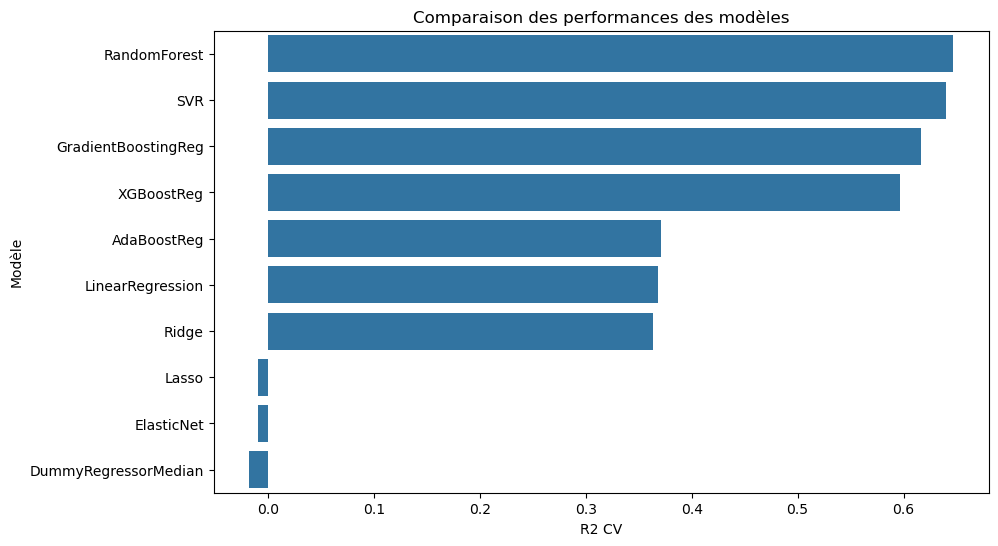

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 CV', y='Modèle', data=df_sorted_by_performance)
plt.title('Comparaison des performances des modèles')
plt.show()

Les modèles Ridge, Lasso, LinearRegression sont les 3 meilleurs modèles avec des performances assez similaires. Nous allons etudier chacun d'eux pour voir lequel sera le meilleur une fois les hyperparamètres trouvés.

## Regression Ridge

## Random Forest

## SVR

### Le modèle de base

In [121]:
# Créer le modèle SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Entraîner le modèle sur les données d'entraînement mises à l'échelle
svr_model.fit(X_train_scaled, y_train)

# Prédire sur l'ensemble de test mis à l'échelle
y_pred_svr = svr_model.predict(X_test_scaled)

# Calculer les métriques pour le modèle SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_svr - y_test) / (np.abs(y_pred_svr) + np.abs(y_test)))

print("Métriques pour le modèle SVR :")
print("RMSE: {:.2f}".format(rmse_svr))
print("MAE: {:.2f}".format(mae_svr))
print("R2: {:.2f}".format(r2_svr))
print("SMAPE: {:.2f}%".format(smape_svr))

Métriques pour le modèle SVR :
RMSE: 0.66
MAE: 0.49
R2: 0.66
SMAPE: 3.38%


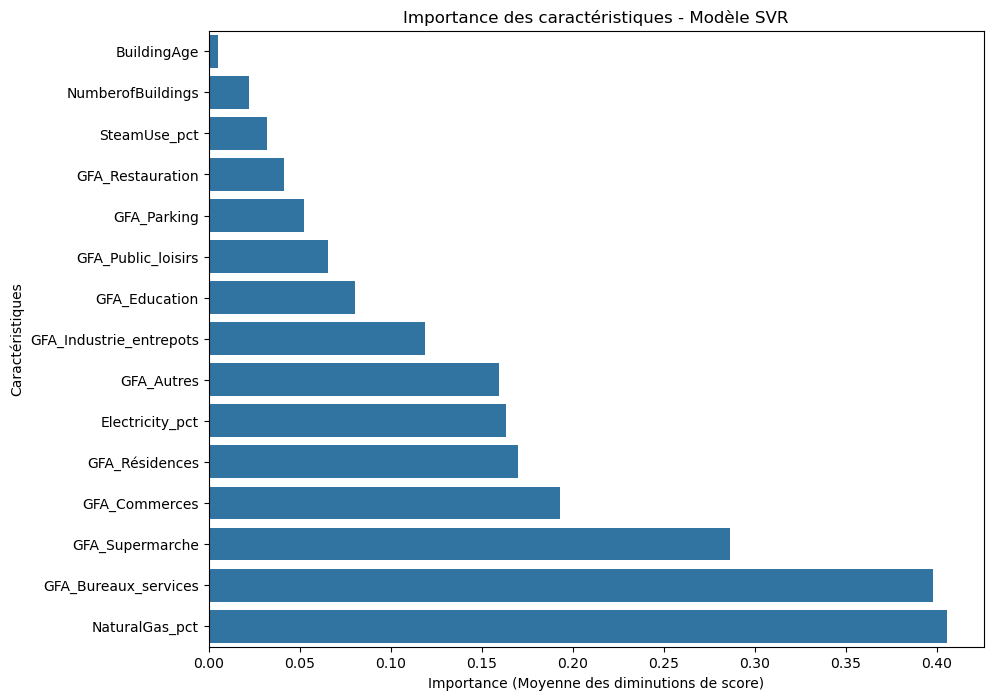

In [122]:
# Calculer l'importance des caractéristiques par permutation
perm_importance = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=30, random_state=0)

# Créer un DataFrame pour stocker les features et leur importance
features_svr = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})

# Tri des caractéristiques par importance décroissante
features_svr = features_svr.sort_values('Importance', ascending=True)

# Création du graphique
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=features_svr)
plt.title('Importance des caractéristiques - Modèle SVR')
plt.xlabel('Importance (Moyenne des diminutions de score)')
plt.ylabel('Caractéristiques')
plt.show()

### Recherche des hyperparamètres

In [123]:
# Définition de l'espace des hyperparamètres pour RandomizedSearchCV
param_distributions = {
    'C': loguniform(1e-3, 1e3), 
    'epsilon': uniform(0.01, 1), 
    'gamma': loguniform(1e-4, 1e-1) 
}

# Création de l'objet RandomizedSearchCV pour une SVR
random_search_svr = RandomizedSearchCV(estimator=SVR(kernel='rbf'), 
                                        param_distributions=param_distributions,
                                        n_iter=100,  
                                        scoring='neg_mean_squared_error',  
                                        cv=5,  
                                        random_state=0, 
                                        verbose=1)  

# Exécution de la recherche aléatoire
random_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR: ", random_search_svr.best_params_)
meilleur_score_rmse_svr = np.sqrt(-random_search_svr.best_score_) 
print("Meilleur score (RMSE) pour SVR: ", meilleur_score_rmse_svr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs hyperparamètres (RandomizedSearchCV) pour SVR:  {'C': 8.177482436211173, 'epsilon': 0.44141843543397397, 'gamma': 0.04893727555349513}
Meilleur score (RMSE) pour SVR:  0.6293104694609668


In [124]:
# Définition de la grille d'hyperparamètres à explorer
param_grid_svr = {
    'C': np.linspace(start=max(0.1, 4.935798091294871 - 1), stop=4.935798091294871 + 1, num=10),
    'epsilon': np.linspace(start=max(0.01, 0.13381998284944152 - 0.05), stop=0.13381998284944152 + 0.05, num=10),
    'gamma': np.linspace(start=max(1e-5, 0.0349965060627184 - 0.01), stop=0.0349965060627184 + 0.01, num=10)
}

# Création de l'objet GridSearchCV pour une SVR
grid_search_svr = GridSearchCV(estimator=SVR(kernel='rbf'), 
                               param_grid=param_grid_svr, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               n_jobs=-1, 
                               verbose=1)

# Exécution de la recherche par grille sur l'ensemble d'entraînement
grid_search_svr.fit(X_train_scaled, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour SVR: ", grid_search_svr.best_params_)

# Calcul de la RMSE sur l'ensemble de test avec le meilleur modèle trouvé
y_pred_gs_svr = grid_search_svr.best_estimator_.predict(X_test_scaled)
rmse_gs_svr = np.sqrt(mean_squared_error(y_test, y_pred_gs_svr))
mae_gs_svr = mean_absolute_error(y_test, y_pred_gs_svr)
r2_gs_svr = r2_score(y_test, y_pred_gs_svr)
smape_svr = 100 * np.mean(2 * np.abs(y_pred_gs_svr - y_test) / (np.abs(y_pred_gs_svr) + np.abs(y_test)))

print("RMSE avec GridSearchCV pour SVR: {:.4f}".format(rmse_gs_svr))
print("MAE avec GridSearchCV pour SVR: {:.4f}".format(mae_gs_svr))
print("R2 avec GridSearchCV pour SVR: {:.4f}".format(r2_gs_svr))
print("SMAPE avec GridSearchCV pour SVR: {:.4f}%".format(smape_svr))


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Meilleurs hyperparamètres pour SVR:  {'C': 5.935798091294871, 'epsilon': 0.1838199828494415, 'gamma': 0.042774283840496176}
RMSE avec GridSearchCV pour SVR: 0.6565
MAE avec GridSearchCV pour SVR: 0.4725
R2 avec GridSearchCV pour SVR: 0.6572
SMAPE avec GridSearchCV pour SVR: 3.2654%


In [125]:
# Meilleurs hyperparamètres obtenus de GridSearchCV pour SVR
best_params_svr = grid_search_svr.best_params_

# Configuration du modèle SVR avec les meilleurs hyperparamètres
best_svr_model = SVR(**best_params_svr)

# Métriques à évaluer lors de la validation croisée
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Exécution de la validation croisée (5 plis)
cv_results_svr = cross_validate(best_svr_model, X_train_scaled, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Calcul et affichage des métriques moyennes pour chaque pli
rmse_scores_svr = np.sqrt(-cv_results_svr['test_neg_mean_squared_error'])
mae_scores_svr = -cv_results_svr['test_neg_mean_absolute_error']
r2_scores_svr = cv_results_svr['test_r2']

# Affichage avec écart type
print(f"Validation Croisée RMSE pour SVR: {rmse_scores_svr.mean():.4f} (± {rmse_scores_svr.std():.4f})")
print(f"Validation Croisée MAE pour SVR: {mae_scores_svr.mean():.4f} (± {mae_scores_svr.std():.4f})")
print(f"Validation Croisée R² pour SVR: {r2_scores_svr.mean():.4f} (± {r2_scores_svr.std():.4f})")

Validation Croisée RMSE pour SVR: 0.6167 (± 0.0407)
Validation Croisée MAE pour SVR: 0.4635 (± 0.0286)
Validation Croisée R² pour SVR: 0.6685 (± 0.0495)


In [126]:
best_svr_model.fit(X_train_scaled, y_train) 

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_svr_model.predict(X_train_scaled)

# Prédictions sur l'ensemble de test
y_test_pred = best_svr_model.predict(X_test_scaled)

# Calcul des métriques pour l'ensemble d'entraînement
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_smape = 100 * np.mean(2 * np.abs(y_train_pred - y_train) / (np.abs(y_train_pred) + np.abs(y_train)))

# Calcul des métriques pour l'ensemble de test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_smape = 100 * np.mean(2 * np.abs(y_test_pred - y_test) / (np.abs(y_test_pred) + np.abs(y_test)))

# Affichage des métriques
print("Ensemble d'entraînement : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(train_rmse, train_r2, train_mae, train_smape))
print("Ensemble de test : RMSE = {:.2f}, R² = {:.2f}, MAE = {:.2f}, SMAPE = {:.2f}%".format(test_rmse, test_r2, test_mae, test_smape))


Ensemble d'entraînement : RMSE = 0.54, R² = 0.75, MAE = 0.38, SMAPE = 2.68%
Ensemble de test : RMSE = 0.66, R² = 0.66, MAE = 0.47, SMAPE = 3.27%


## Analyse des erreurs

### Avec les cibles en log

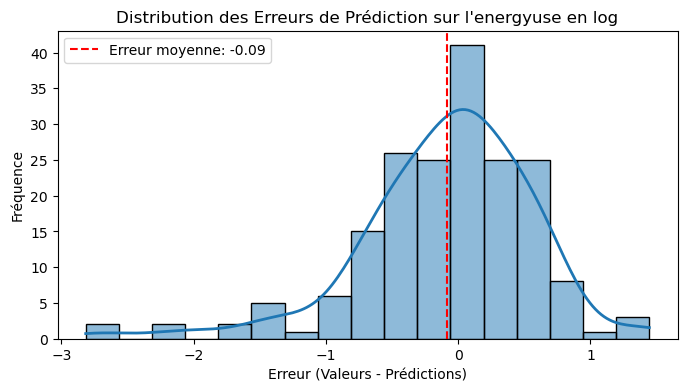

In [127]:
# Calcul des erreurs
errors = y_test - y_test_pred

# Calcul de l'erreur moyenne
mean_error = np.mean(errors)

# Visualisation de la distribution des erreurs
# Couleurs de la palette tab10
colors_tab10 = plt.cm.tab10(np.arange(10))
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, color=colors_tab10[0], line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(mean_error, color='red', linestyle='--', label=f'Erreur moyenne: {mean_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction sur l\'energyuse en log')
plt.xlabel('Erreur (Valeurs - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

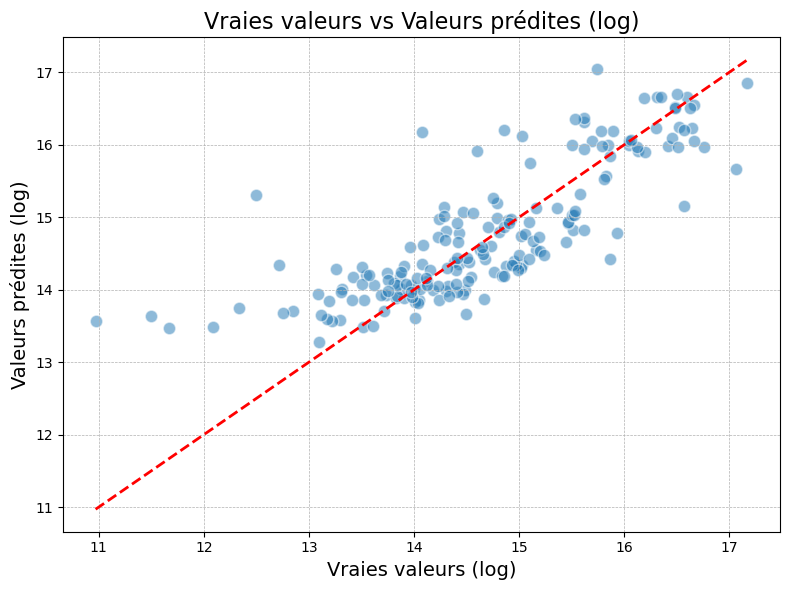

In [128]:
plt.figure(figsize=(8, 6))  # Augmenter la taille du graphique
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='w', s=80)  # Ajouter des bords blancs pour mieux distinguer les points superposés
plt.title('Vraies valeurs vs Valeurs prédites (log)', fontsize=16)
plt.xlabel('Vraies valeurs (log)', fontsize=14)
plt.ylabel('Valeurs prédites (log)', fontsize=14)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Grille plus fine
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)  # Grille mineure
plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour bien remplir la figure
plt.show()


### Avec les valeurs réelles

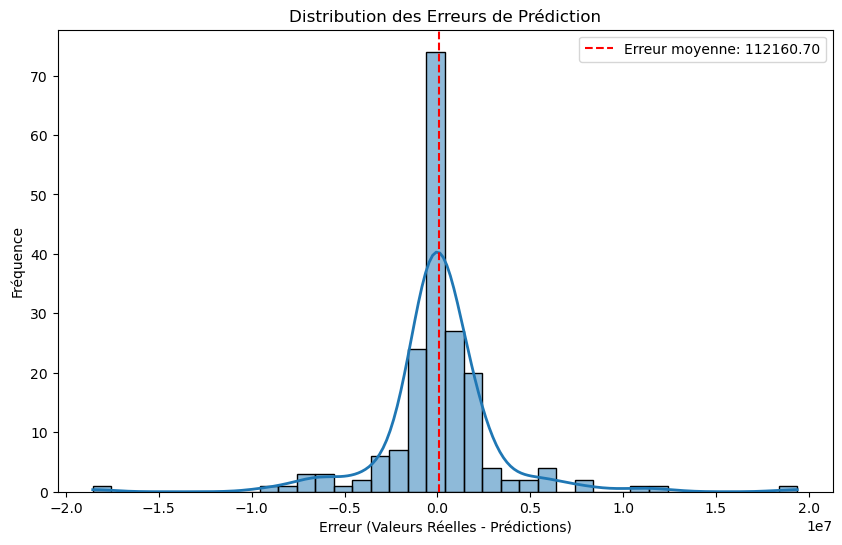

In [129]:
# Conversion des prédictions et des valeurs réelles de test de log à l'échelle originale
y_test_pred_original = np.exp(y_test_pred) 
y_test_original = np.exp(y_test)  

# Calcul des erreurs
errors = y_test_original - y_test_pred_original

# Calcul de l'erreur moyenne
mean_error = np.mean(errors)

# Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color=colors_tab10[0], binwidth=1000000, line_kws={'color': colors_tab10[1], 'linewidth': 2})
plt.axvline(mean_error, color='red', linestyle='--', label=f'Erreur moyenne: {mean_error:.2f}')
plt.title('Distribution des Erreurs de Prédiction')
plt.xlabel('Erreur (Valeurs Réelles - Prédictions)')
plt.ylabel('Fréquence')
plt.legend()

plt.show()

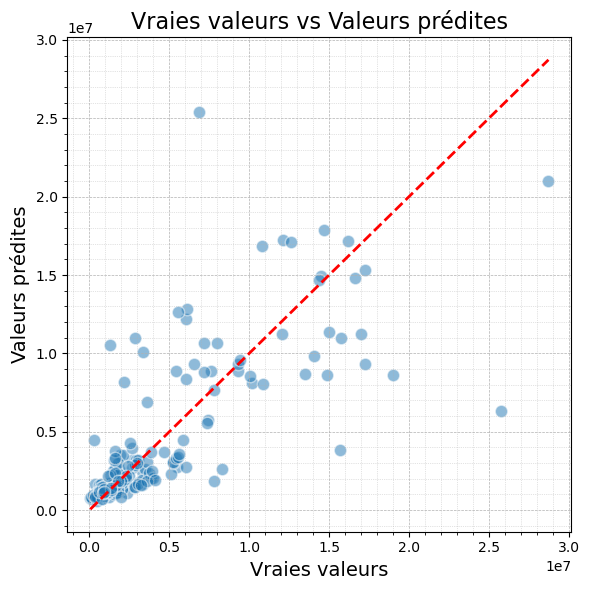

In [130]:
plt.figure(figsize=(6, 6)) 
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5, edgecolors='w', s=80)  
plt.title('Vraies valeurs vs Valeurs prédites', fontsize=16)
plt.xlabel('Vraies valeurs', fontsize=14)
plt.ylabel('Valeurs prédites', fontsize=14)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', lw=2, linestyle='--')  # Ligne y=x
plt.grid(True, which='major', linestyle='--', linewidth=0.5) 
plt.minorticks_on() 
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7) 
plt.tight_layout() 
plt.show()

In [131]:
# Création d'un DataFrame avec les valeurs réelles et prédites
df_errors = pd.DataFrame({'Valeurs réelles': y_test_original, 'Valeurs prédites': y_test_pred_original})


# Calcul des erreurs absolues et ajout en tant que nouvelle colonne
df_errors['Erreurs absolues'] = abs(df_errors['Valeurs réelles'] - df_errors['Valeurs prédites'])

# Trier le DataFrame par les erreurs absolues de façon décroissante
df_errors_sorted = df_errors.sort_values('Erreurs absolues', ascending=False)

# Afficher les 15 erreurs les plus grandes
print(df_errors_sorted.head(15))

     Valeurs réelles  Valeurs prédites  Erreurs absolues
254      25736450.00      6.354971e+06      1.938148e+07
276       6837936.00      2.539341e+07      1.855547e+07
31       15684371.00      3.826856e+06      1.185751e+07
292      19009360.00      8.597694e+06      1.041167e+07
768       1300765.50      1.053479e+07      9.234022e+06
933       2842128.00      1.095466e+07      8.112529e+06
265      17267470.00      9.322526e+06      7.944944e+06
75       28731502.00      2.100408e+07      7.727422e+06
921       5574345.00      1.265925e+07      7.084903e+06
579       3347245.25      1.009548e+07      6.748236e+06
24        6088417.50      1.283137e+07      6.742957e+06
146      14843382.00      8.601536e+06      6.241846e+06
73        6057410.00      1.220768e+07      6.150267e+06
278      10775646.00      1.685040e+07      6.074752e+06
467       2188575.25      8.162902e+06      5.974327e+06


In [132]:
indices_plus_gd_erreurs = df_errors_sorted.head(15).index
df_top_errors = df.loc[indices_plus_gd_erreurs]
df_top_errors

,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Education,GFA_Commerces,GFA_Bureaux_services,GFA_Industrie_entrepots,GFA_Autres,GFA_Restauration,GFA_Supermarche,GFA_Parking,Log_TotalGHGEmissions,Log_SiteEnergyUseWN
254,1.0,6,NaN,25736450.00,710.70,10,2,0.000000,54.789107,44.803153,0.0,0.0,0.0,0.0,0.0,0.0,119570.0,0.0,0.0,23869.0,6.566250,17.063419
276,1.0,1,NaN,6837936.00,46.52,46,1,0.000000,97.589931,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,152511.0,0.0,0.0,0.0,3.839882,15.737996
31,1.0,6,NaN,15684371.00,481.97,33,6,33.968863,64.684220,0.000000,0.0,0.0,0.0,0.0,57194.0,0.0,12377.0,0.0,0.0,30209.0,6.177882,16.568175
292,1.0,5,NaN,19009360.00,341.23,17,2,0.000000,76.358538,23.641462,0.0,134197.0,0.0,0.0,0.0,0.0,1718.0,5803.0,0.0,0.0,5.832557,16.760442
768,4.0,2,92.0,1300765.50,28.64,7,1,0.000000,55.160365,34.214776,0.0,0.0,31100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.354804,14.078463
933,1.0,3,NaN,2842128.00,58.28,27,4,0.000000,66.431315,29.888555,38800.0,0.0,0.0,0.0,4236.0,0.0,0.0,0.0,0.0,156000.0,4.065259,14.860064
265,1.0,13,25.0,17267470.00,119.03,18,2,0.000000,98.880374,0.000000,0.0,0.0,0.0,0.0,145491.0,0.0,3228.0,0.0,0.0,145084.0,4.779376,16.664335
75,1.0,5,1.0,28731502.00,661.04,89,2,0.000000,65.243512,34.756481,0.0,0.0,0.0,0.0,156546.0,0.0,0.0,0.0,0.0,39000.0,6.493814,17.173505
921,2.0,2,NaN,5574345.00,38.17,4,1,0.000000,98.224383,0.000000,0.0,0.0,0.0,0.0,138602.0,0.0,0.0,0.0,0.0,0.0,3.642050,15.533685
579,5.0,1,NaN,3347245.25,96.15,11,1,0.000000,44.049655,48.306499,0.0,0.0,57952.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.565909,15.023648


# Modélisation avec l'Energy Star Score

# Comparaison et conclusion